In [37]:
import sys
sys.path.append('../')

In [96]:
import numpy as np
import rebound
import matplotlib.pyplot as plt
import matplotlib
import random
import dill
import sys
import pandas as pd
import spock
from spock import StabilityRegression

try:
    plt.style.use('paper')
except:
    pass

spockoutfile = 'alysa-datafiles/spockprobstesttrio.npz'

stride = 1
nsim_list = np.arange(0, 17500)

In [100]:
all_parts = []

for i in range(40): 
    start = i * 437
    end = (i+1)*437
    
    spockoutfile = 'alysa-datafiles/spockprobstesttrio{}_to_{}.npz'.format(start, end)
    
    part = [
        np.load(spockoutfile)['nsim_list'], np.load(spockoutfile)['probs']
    ]
    all_parts.append(np.array(part))
    
all_parts = np.concatenate(all_parts, 1)

In [101]:
all_parts[0].shape

(1760,)

In [102]:
used_axes = np.argwhere(np.sum(all_parts[0].astype(np.int)[:, None] - nsim_list[None] == 0, axis=0))[:, 0]

In [103]:
used_axes

array([    0,    10,    20, ..., 17453, 17463, 17473])

In [106]:
nsim_list = nsim_list[used_axes]

In [121]:
#######################################################################
## read initial condition file

infile_delta_2_to_10 = 'alysa-datafiles/initial_conditions_delta_2_to_10.npz'
infile_delta_10_to_13 = 'alysa-datafiles/initial_conditions_delta_10_to_13.npz'

ic1 = np.load(infile_delta_2_to_10)
ic2 = np.load(infile_delta_10_to_13)

m_star = ic1['m_star'] # mass of star
m_planet = ic1['m_planet'] # mass of planets
rh = (m_planet/3.) ** (1./3.)

Nbody = ic1['Nbody'] # number of planets
year = 2.*np.pi # One year in units where G=1
tf = ic1['tf'] # end time in years

a_init = np.concatenate([ic1['a'], ic2['a']], axis=1) # array containing initial semimajor axis for each delta,planet
f_init = np.concatenate([ic1['f'], ic2['f']], axis=1) # array containing intial longitudinal position for each delta, planet, run

#######################################################################
## create rebound simulation and predict stability for each system in nsim_list

In [122]:
infile_delta_2_to_10 = 'alysa-datafiles/initial_conditions_delta_2_to_10.npz'
infile_delta_10_to_13 = 'alysa-datafiles/initial_conditions_delta_10_to_13.npz'

outfile_nbody_delta_2_to_10 = 'alysa-datafiles/merged_output_files_delta_2_to_10.npz'
outfile_nbody_delta_10_to_13 = 'alysa-datafiles/merged_output_files_delta_10_to_13.npz'

## load hill spacing

ic_delta_2_to_10 = np.load(infile_delta_2_to_10)
ic_delta_10_to_13 = np.load(infile_delta_10_to_13)

delta_2_to_10 = ic_delta_2_to_10['delta']
delta_10_to_13 = ic_delta_10_to_13['delta']

delta = np.hstack((delta_2_to_10, delta_10_to_13))
delta=delta[used_axes]

## load rebound simulation first close encounter times

nbody_delta_2_to_10 = np.load(outfile_nbody_delta_2_to_10)
nbody_delta_10_to_13 = np.load(outfile_nbody_delta_10_to_13)

t_exit_delta_2_to_10 = nbody_delta_2_to_10['t_exit']/(0.99)**(3./2)
t_exit_delta_10_to_13 = nbody_delta_10_to_13['t_exit']/(0.99)**(3./2)

t_exit = np.hstack((t_exit_delta_2_to_10, t_exit_delta_10_to_13))
t_exit = t_exit[used_axes]

df = pd.DataFrame(np.array([nsim_list, delta, t_exit]).T, columns=['nsim', 'delta', 't_exit'])
df.head()

,nsim,delta,t_exit
0,0.0,2.000573,1.522785
1,10.0,2.007646,8.882910
2,20.0,2.015118,9.035188
3,30.0,2.018451,3.553164
4,40.0,2.024270,9.695062


In [123]:

model = StabilityRegression()


def pred(nsim):
    sim = rebound.Simulation()
    sim.add(m=m_star)
    sim.G = 4*np.pi**2
    for i in range(Nbody): # add the planets
        sim.add(m=m_planet, a=a_init[i, nsim], f=f_init[i, nsim])
        print(a_init[i, nsim])
    sim.move_to_com()
    sim.init_megno(seed=0)
    sim.integrator="whfast"
    sim.dt = 0.07*sim.particles[1].P
    prob = 10**np.average(np.log10(model.predict(sim, samples=10000)))
    print('Done', flush=True)
    return prob

In [124]:
# from multiprocessing import Pool
# pool = Pool(processes=5)

In [125]:
# nsim_list

In [126]:
# for q in map(pred, nsim_list[:5]):
#     print(q)

In [127]:
len(nsim_list)//10//40

4

In [128]:
# %%time
# res = pool.map(pred, nsim_list[:5])

In [129]:
spockoutfile

'alysa-datafiles/spockprobstesttrio17043_to_17480.npz'

In [130]:
# np.savez(spockoutfile, nsim_list=nsim_list, probs=np.array(res))

In [144]:
infile_delta_2_to_10 = 'alysa-datafiles/initial_conditions_delta_2_to_10.npz'
infile_delta_10_to_13 = 'alysa-datafiles/initial_conditions_delta_10_to_13.npz'

outfile_nbody_delta_2_to_10 = 'alysa-datafiles/merged_output_files_delta_2_to_10.npz'
outfile_nbody_delta_10_to_13 = 'alysa-datafiles/merged_output_files_delta_10_to_13.npz'

spockoutfile_ml_probs = 'alysa-datafiles/stability-probs-sims-spockalltrios.npz'

## load hill spacing

ic_delta_2_to_10 = np.load(infile_delta_2_to_10)
ic_delta_10_to_13 = np.load(infile_delta_10_to_13)

delta_2_to_10 = ic_delta_2_to_10['delta']
delta_10_to_13 = ic_delta_10_to_13['delta']

delta = np.hstack((delta_2_to_10, delta_10_to_13))
delta=delta[used_axes]

## load rebound simulation first close encounter times

nbody_delta_2_to_10 = np.load(outfile_nbody_delta_2_to_10)
nbody_delta_10_to_13 = np.load(outfile_nbody_delta_10_to_13)

t_exit_delta_2_to_10 = nbody_delta_2_to_10['t_exit']/(0.99)**(3./2)
t_exit_delta_10_to_13 = nbody_delta_10_to_13['t_exit']/(0.99)**(3./2)

t_exit = np.hstack((t_exit_delta_2_to_10, t_exit_delta_10_to_13))
t_exit = t_exit[used_axes]

log_t_exit = np.log10(t_exit)

spockprobs = np.log10(all_parts[1])#spockml_data['probs']

delta.shape

(1760,)

In [145]:
spockprobs

array([4.        , 4.        , 4.        , ..., 9.90951325, 9.90555769,
       9.94926712])

#  TPR

In [148]:
# surv

In [149]:
# thresh = 0.79
# (spockprobs[survival_true] > thresh).sum()/survival_true.sum()

# FPR

In [150]:
# (spockprobs[survival_false] > thresh).sum()/survival_false.sum()

In [151]:
# survival_false.sum()

In [ ]:
plt.plot()

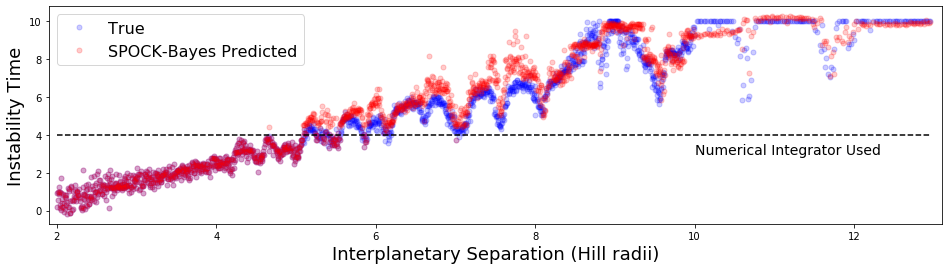

In [182]:
from matplotlib.lines import Line2D

fig, axarr = plt.subplots(1, 1, figsize=(16,4), sharex=True)
plt.subplots_adjust(hspace=0, wspace=0)

ms=5

stride = 4
# axarr[0].plot([np.min(delta), np.max(delta)], [9,9], '--k')
# axarr[0].plot(delta[survival_true][::stride],log_t_exit[survival_true][::stride],'ob', alpha=0.2, markersize=ms,rasterized=True,label='Stable', zorder=0)
# axarr[0].plot(delta[survival_false][::stride],log_t_exit[survival_false][::stride],'or', alpha=0.2, markersize=ms,rasterized=True,label='Unstable', zorder=0)

# axarr[1].plot(delta[survival_true][::stride], spockprobs[survival_true][::stride],'ob', alpha=0.2, markersize=ms*2,rasterized=True, zorder=0)
# axarr[1].plot(delta[survival_false][::stride], spockprobs[survival_false][::stride],'or', alpha=0.2, markersize=ms, rasterized=True, zorder=0)

plt.plot(delta, log_t_exit, 'ob', alpha=0.2, markersize=ms,rasterized=True,zorder=0, label='True')
tmp = spockprobs - spockprobs * (spockprobs <= 4) + log_t_exit * (spockprobs <= 4)
plt.plot(delta, tmp, 'or', alpha=0.2, markersize=ms,rasterized=True, zorder=0, label='SPOCK-Bayes Predicted')

plt.xlabel("Interplanetary Separation (Hill radii)", fontsize=18)
plt.xlim([1.9, 13.1])

plt.ylabel("Instability Time", fontsize=18)


plt.plot([np.min(delta), np.max(delta)], [4,4], '--k')
plt.text(10, 4-1, 'Numerical Integrator Used', fontsize=14)

# axarr[0].legend(loc=2, markerscale=3)

# legend_elements = [Line2D([0], [0], marker='o', lw=0, c='b', markerfacecolor='b', label='Stable', markersize=10),
#                    Line2D([0], [0], marker='o', lw=0, c='r', markerfacecolor='r', label='Unstable', markersize=10)]
plt.legend(loc='upper left', fontsize=16)


plt.savefig('cranmer.pdf',bbox_inches='tight')

